In [2]:
import struct
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d

from integrate_Jyg import *
from integrate_xg import *

In [3]:
# we'll choose the reference density n0 = 1.0 and e = 1.0

dx = 0.05     # , c/w_pe - Grid spacing
mi_me = 16.0  # , me - Mass of ions
Ti = 10.0     # , KeV - ions temperature
v_th = sqrt(Ti / mi_me / 511.0)  # , make sure to divide by mec^2 = 511.0 KeV

postfix = f'{dx}dx_{mi_me}mi_me_{Ti}Ti'


raw_xg = load('integral_of_xg.npy', allow_pickle=True)
raw_ng = load('value_of_ng.npy', allow_pickle=True)

# x values were normalized to rho_i = c/w_pi
#
# normalized to e * n0 * v_th, v_th = sqrt(Ti / mi)
# TODO: find the place for sqrt(2) multiplier
_Jy = interp1d(raw_xg[1] * sqrt(mi_me),
  Jy_value(raw_xg[0]) * v_th / sqrt(2))

# normalized to Bv = sqrt(4 * pi * n0 * mi * v_th^2)
# TODO: find the place for sqrt(2) multiplier
_Bz = interp1d(raw_xg[1][1:] * sqrt(mi_me),
  Bz_value(raw_xg[0][1:]) * sqrt(4 * pi * mi_me * v_th * v_th) / sqrt(2),
  bounds_error=False, fill_value=(0,1))

# normalized to n0 = 1
_ng = interp1d(raw_ng[0], raw_ng[1])
_n  = interp1d(raw_xg[1] * sqrt(mi_me), _ng(raw_xg[0]))


xmax = 10 * sqrt(mi_me)
x_range = np.arange(0, xmax + dx, dx)

Jy = {x: float(_Jy(x)) for x in x_range}
Bz = {x: float(_Bz(x)) for x in x_range}
n  = {x: float(_n(x))  for x in x_range}

# Saving interpolated functions into numpy binaries
np.save(f'../Jy_{postfix}.npy', Jy)
np.save(f'../Bz_{postfix}.npy', Bz)
np.save(f'../n_{postfix}.npy',  n)

# Writing table functions to the binary file
parameters = [0, xmax, dx]

for table, name in zip([Jy, Bz, n], ['Jy', 'Bz', 'n']):
  with open(f'../{name}_{postfix}.bin', 'wb') as file:
    plain_dict = []
    for x, v in table.items():
      plain_dict.append(x)
      plain_dict.append(v)
    
    result = parameters + plain_dict
    file.write(struct.pack('d' * len(result), *result))


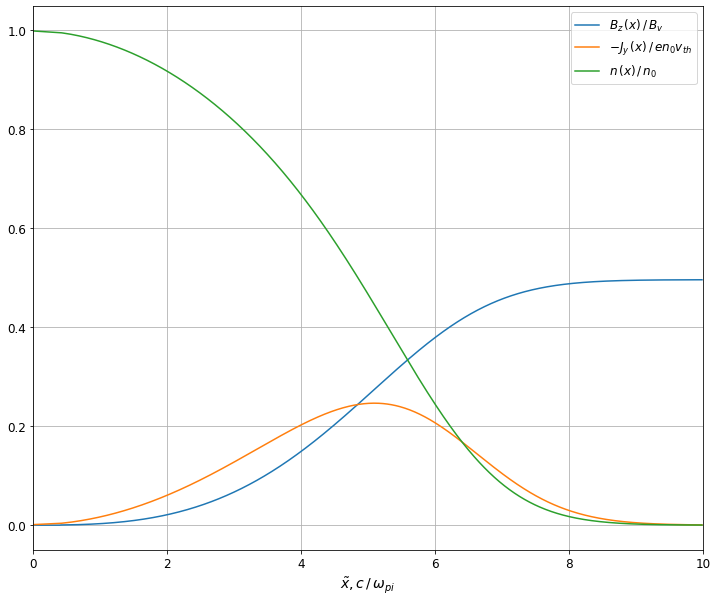

In [4]:
fig = plt.figure(figsize=(12,10))

plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)   # fontsize of the tick labels
plt.rc('ytick', labelsize=12)   # fontsize of the tick labels
plt.rc('legend', fontsize=12)   # legend fontsize

Bz = load(f'../Bz_{postfix}.npy', allow_pickle=True).item()
plt.plot(np.array(list(Bz.keys())) / sqrt(mi_me), np.array(list(Bz.values())) / sqrt(4 * pi * mi_me * v_th * v_th), label='$B_z\,(x)\,/\,B_v$')
# plt.fill_between(np.array(list(Bz.keys())) / sqrt(mi_me), 0, np.array(list(Bz.values())) / sqrt(4 * pi * mi_me * v_th * v_th), alpha = 0.4)

Jy = load(f'../Jy_{postfix}.npy', allow_pickle=True).item()
plt.plot(np.array(list(Jy.keys())) / sqrt(mi_me), -np.array(list(Jy.values())) / v_th, label='$- J_y\,(x)\,/\,e n_0 v_{th}$')
# plt.fill_between(np.array(list(Jy.keys())) / sqrt(mi_me), 0, -np.array(list(Jy.values())) / v_th, alpha = 0.4)

n = load(f'../n_{postfix}.npy', allow_pickle=True).item()
plt.plot(np.array(list(n.keys())) / sqrt(mi_me), n.values(), label='$n\,(x)\,/\,n_0$')
# plt.fill_between(np.array(list(n.keys())) / sqrt(mi_me), 0, np.array(list(n.values())), alpha = 0.4)

plt.xlabel('$\\tilde{x}, c\,/\,\\omega_{pi}$')
plt.xlim((0, 10))
plt.grid()

plt.legend()